In [66]:
!pip install matplotlib

In [1]:
import torch
import torchvision
import  torchvision.transforms as transforms

In [31]:
checkpoint = torch.load('results/wm811k-supervised/model_best.pth.tar')

In [2]:
from utils.common import create_model
from argparse import Namespace

In [75]:
args = Namespace()
args.arch = 'wideresnet'
args.model_depth = 28
args.model_width = 2
args.num_classes = 8

In [76]:
best_f1 = checkpoint['best_f1']
model = create_model(args)

Namespace(arch='wideresnet', model_depth=28, model_width=2, num_classes=8)
3


In [77]:
model

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
        (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
        (relu2): LeakyReLU(negative_slope=0.1, inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
        (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
        (conv1): Conv2d(32, 32, kernel_size=(

In [78]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [79]:
#load pretrained resnet model
# model = torchvision.models.resnet50(pretrained=True)
# print(model)

In [86]:

#define transforms to preprocess input image into format expected by model
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
# inv_normalize = transforms.Normalize(
#     mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
#     std=[1/0.229, 1/0.224, 1/0.255]
# )

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # normalize,
])


transform_tmp = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


In [83]:
import numpy as np
import matplotlib.pyplot as plt

def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False

    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of highest score w.r.t. input
    #so set requires_grad to True for input
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [84]:
from PIL import Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: name 'slc' is not defined

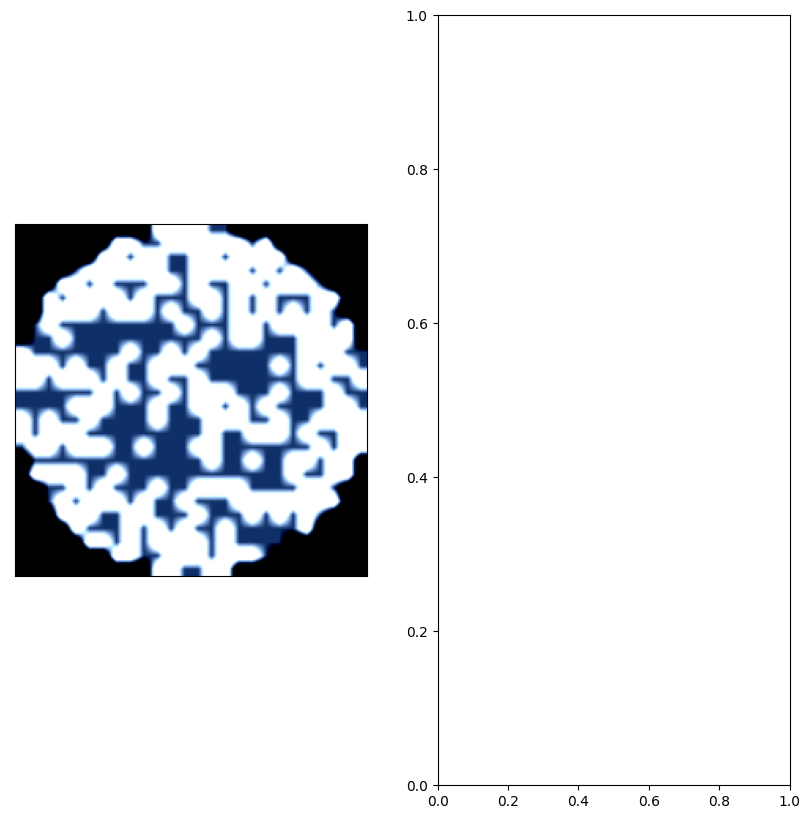

In [85]:
img = Image.open('data/wm811k/labeled/train/random/000602.png').convert('RGB')
input = transform(img)
input = transform_tmp(img)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(slc.numpy(), cmap=plt.cm.hot)
plt.xticks([])
plt.yticks([])
plt.show()



In [64]:
img = Image.open('data/wm811k/labeled/train/random/000602.png').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  ...
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]]

 [[ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  ...
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]]

 [[ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  ...
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  [ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]]

 ...

 [[ 0.0000000e+00  5.3405760e-08 -5.4133326e-02]
  [ 0.0000000e+00  5.3405760e-08 -5.413

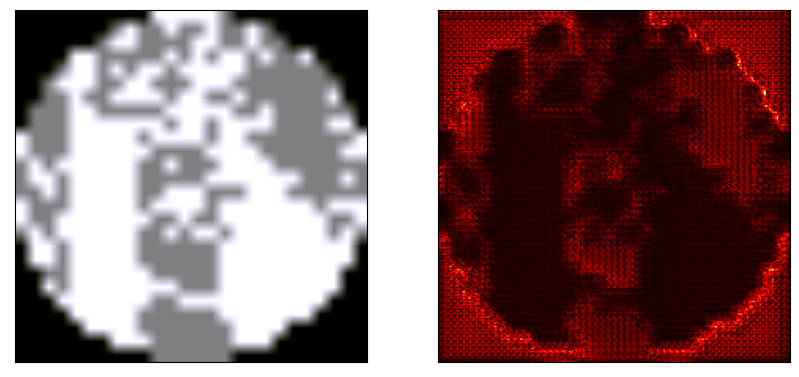

In [68]:
img = Image.open('data/wm811k/labeled/train/random/000983.png').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


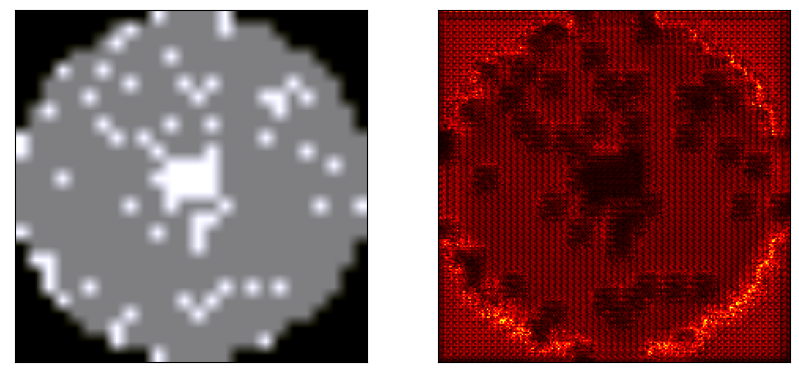

In [21]:
img = Image.open('data/wm811k/labeled/train/center/006624.png').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


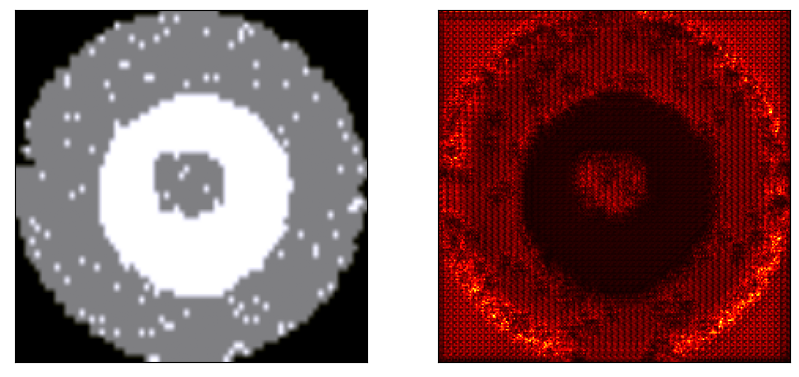

In [22]:
img = Image.open('data/wm811k/labeled/train/donut/007934.png').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


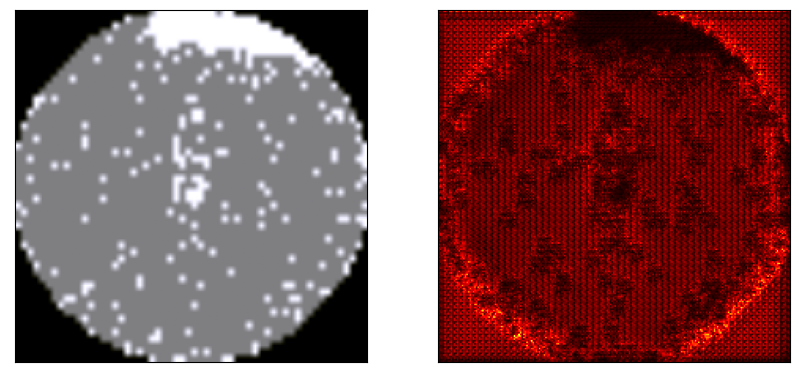

In [23]:
img = Image.open("data/wm811k/labeled/train/edge-loc/000042.png").convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


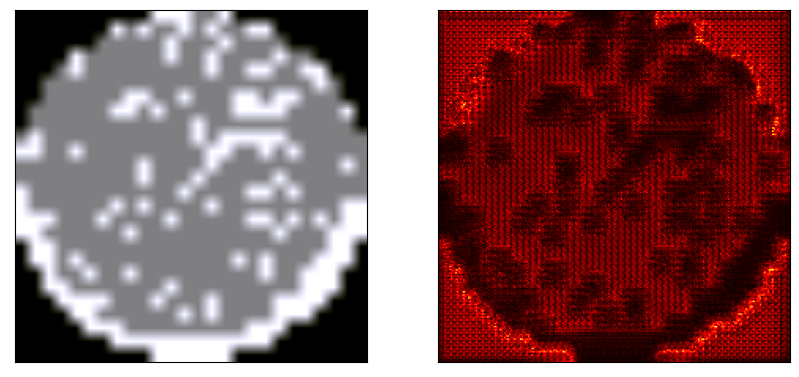

In [24]:
img = Image.open("data/wm811k/labeled/train/edge-ring/000186.png").convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


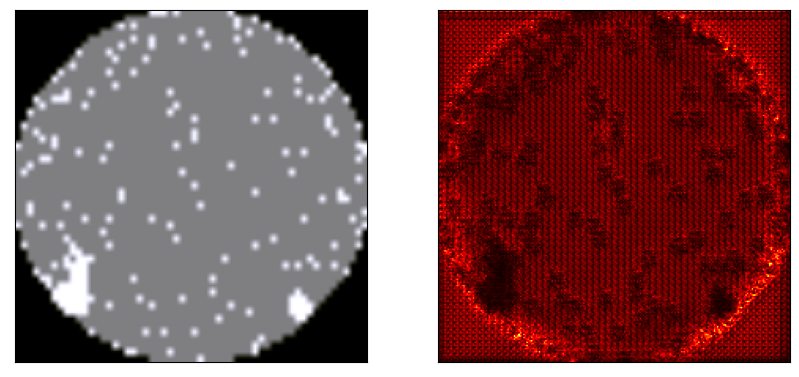

In [25]:
img = Image.open("data/wm811k/labeled/train/loc/000047.png").convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


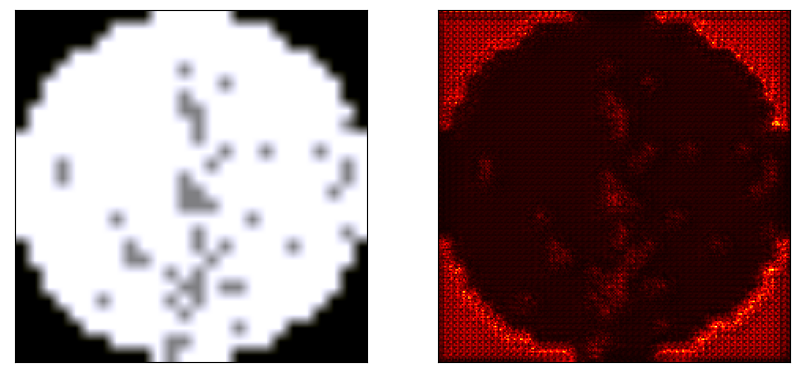

In [26]:
img = Image.open("data/wm811k/labeled/train/near-full/003143.png").convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


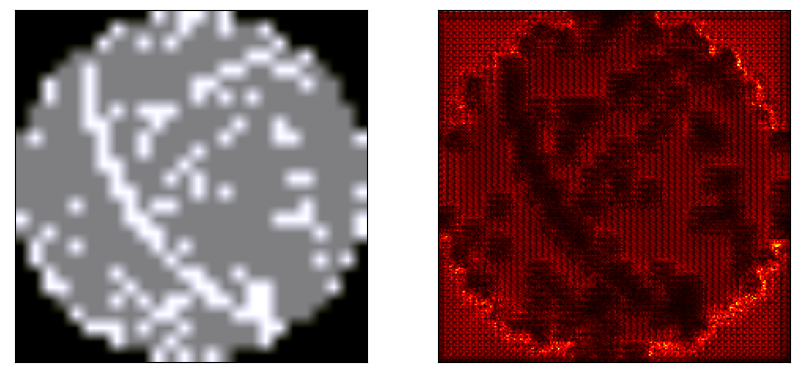

In [27]:
img = Image.open("data/wm811k/labeled/train/scratch/003038.png").convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


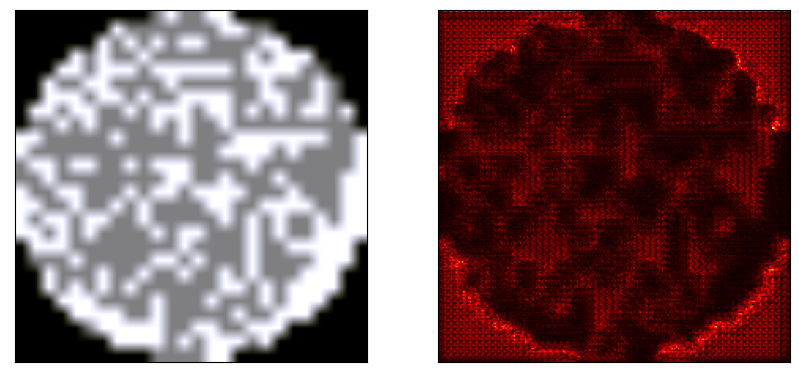

In [28]:
img = Image.open("data/wm811k/labeled/train/random/002271.png").convert('RGB')
saliency(img, model)